In [1]:
import os
import zipfile
import numpy as np
import sys
import pandas as pd
import tensorflow as tf
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from kaggle_datasets import KaggleDatasets
from numpy import save
from numpy import asarray
from os import listdir
import matplotlib as mpl
from numpy import load
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
validation_df=pd.read_csv('/kaggle/input/bestmodelvalidationused/validation.csv')

In [3]:
path_for_gcs=KaggleDatasets().get_gcs_path('aptos2019-blindness-detection')
print(path_for_gcs)

gs://kds-db6211cd4531736bf26a8f5404ff6a6e65a1dfc68ccc6145be1375fd


In [4]:
validation_files_path=[path_for_gcs+'/train_images/'+ fname for fname in validation_df['id_code']]
validation_labels=list(validation_df['diagnosis'])

In [5]:
#TPU setup
try:
    tpu=tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU")
except ValueError:
    tpu=None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy=tf.distribute.experimental.TPUStrategy(tpu)
else:
    print("Not Running on TPU")
    tpu_strategy=tf.distribute.get_strategy()
print("REPLICAS ",tpu_strategy.num_replicas_in_sync)

Not Running on TPU
REPLICAS  1


In [6]:
#predefined variable
IMG_WIDTH=512
IMG_HEIGHT=512
BATCH_SIZE=16*tpu_strategy.num_replicas_in_sync#take thumb rule
AUTOTUNE = tf.data.experimental.AUTOTUNE 

In [7]:
def parse_function_for_validate(filename,label):
    image_string=tf.io.read_file(filename)
    image_decoded=tf.image.decode_png(image_string,channels=3)
    image_resized=tf.image.resize(image_decoded,[IMG_WIDTH,IMG_HEIGHT])
    image_normalized=image_resized/255.0
    label=tf.dtypes.cast(label,tf.int32)
    label=tf.one_hot(label,5)
    return image_normalized,label

In [8]:
def create_dataset(filenames, labels, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    if is_training:
        dataset = dataset.map(parse_function_for_train, num_parallel_calls=AUTOTUNE)
    else:
        dataset = dataset.map(parse_function_for_validate, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [9]:
validation_dataset=create_dataset(validation_files_path,validation_labels,is_training=False)

In [10]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

In [11]:
metrices=[tf.keras.metrics.CategoricalAccuracy(name='acc')]

In [12]:
with tpu_strategy.scope():
    enet = efn.EfficientNetB7(
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        weights=None,#'imagenet if training for first time'
        include_top=False
    )
    enet.trainable = True 
    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss = 'categorical_crossentropy',
        metrics=metrices
    )
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 12805     
Total params: 64,110,485
Trainable params: 63,799,765
Non-trainable params: 310,720
_________________________________________________________________


In [13]:
%matplotlib inline

In [14]:
model.load_weights('/kaggle/input/projectfinal2/efficientnetb7epochs36weightswithoversamplingverticalimgaugpart1.hdf5')

In [15]:
history1to10=np.load('/kaggle/input/histories/history1to10.npy',allow_pickle=True)
history11to20=np.load('/kaggle/input/histories/history10to20.npy',allow_pickle=True)

In [16]:
history1to10

array([{'loss': [0.7429718223970327], 'acc': [0.7285448], 'val_loss': [2.3325783014297485], 'val_acc': [0.5652174]},
       {'loss': [0.2829801651524074], 'acc': [0.90298504], 'val_loss': [2.1125738620758057], 'val_acc': [0.47826087]},
       {'loss': [0.16766206564298317], 'acc': [0.94962686], 'val_loss': [1.4791942834854126], 'val_acc': [0.6956522]},
       {'loss': [0.10276847057489318], 'acc': [0.9785448], 'val_loss': [1.0975428223609924], 'val_acc': [0.6956522]},
       {'loss': [0.08571873897158389], 'acc': [0.9692164], 'val_loss': [1.3228583931922913], 'val_acc': [0.86956525]},
       {'loss': [0.08110816198498455], 'acc': [0.9757463], 'val_loss': [1.127720832824707], 'val_acc': [0.86956525]},
       {'loss': [0.0722345094015794], 'acc': [0.98600745], 'val_loss': [1.5155670046806335], 'val_acc': [0.7826087]},
       {'loss': [0.0604201923611004], 'acc': [0.98134327], 'val_loss': [1.1462824940681458], 'val_acc': [0.826087]},
       {'loss': [0.06378606799989939], 'acc': [0.981343

In [17]:
history11to20

array([{'loss': [0.6259168341978273], 'acc': [0.7835821], 'val_loss': [0.9490711987018585], 'val_acc': [0.73913044]},
       {'loss': [0.2883383865231898], 'acc': [0.9048507], 'val_loss': [0.9239094257354736], 'val_acc': [0.826087]},
       {'loss': [0.20106189064125515], 'acc': [0.9393656], 'val_loss': [1.2790570855140686], 'val_acc': [0.7826087]},
       {'loss': [0.1525687783845325], 'acc': [0.95522386], 'val_loss': [0.9420528411865234], 'val_acc': [0.7826087]},
       {'loss': [0.12183386184719962], 'acc': [0.95988804], 'val_loss': [1.1153591871261597], 'val_acc': [0.826087]},
       {'loss': [0.10094482340474627], 'acc': [0.9720149], 'val_loss': [0.9824252724647522], 'val_acc': [0.7826087]},
       {'loss': [0.08775933881971373], 'acc': [0.9766791], 'val_loss': [1.1176316142082214], 'val_acc': [0.7826087]},
       {'loss': [0.08796753801071822], 'acc': [0.9766791], 'val_loss': [1.5668790936470032], 'val_acc': [0.826087]},
       {'loss': [0.08804098399939822], 'acc': [0.9776119], 

In [18]:
def plot(history1,history2):
    acc=[]
    val_acc=[]
    loss=[]
    val_loss=[]
    for hist in history1:
        acc.append(hist['acc'])
        loss.append(hist['loss'])
        val_acc.append(hist['val_acc'])
        val_loss.append(hist['val_loss'])
    for hist in history2:
        acc.append(hist['acc'])
        loss.append(hist['loss'])
        val_acc.append(hist['val_acc'])
        val_loss.append(hist['val_loss'])
    epochs=range(len(acc))
    plt.plot(epochs,acc)
    plt.plot(epochs,val_acc)
    plt.title('Training accuracy and Validation accuracy')
    plt.figure()
    plt.plot(epochs,loss)
    plt.plot(epochs,val_loss)
    plt.title('Training and validation loss')

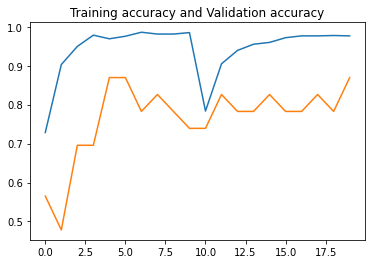

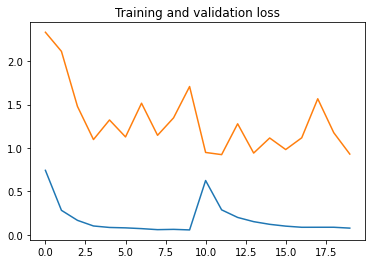

In [19]:
plot(history1to10,history11to20)

In [20]:
from sklearn.metrics import classification_report

In [21]:
predictions=model.predict(validation_dataset)

In [22]:
predictions=list(np.argmax(predictions,1))

In [23]:
import seaborn as sn

In [24]:
def plotconfusionmatrix(y_actual,y_pred):
    data = {'y_Actual':    y_actual,'y_Predicted': y_pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()

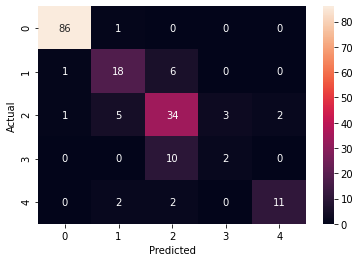

In [25]:
plotconfusionmatrix(validation_labels,predictions)